**Author:** Elias Rafael Ruiz-Morales

**Institution:** Wellcome Sanger institute

**August, 2023**


---

## Data loading -Malaria samples


In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib
import os
import sys
%matplotlib inline

import seaborn as sns
import seaborn as sb
import anndata
import matplotlib as mpl
import pickle 
import scrublet as scr

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 1  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = '../results/images/preprocessing/'

sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

-----
anndata     0.7.5
scanpy      1.7.1
sinfo       0.3.1
-----
PIL                 8.1.2
anndata             0.7.5
anyio               NA
attr                20.3.0
babel               2.9.0
backcall            0.2.0
brotli              NA
cairo               1.20.0
certifi             2020.12.05
cffi                1.14.5
chardet             4.0.0
cloudpickle         1.6.0
colorama            0.4.4
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.03.1
dateutil            2.8.1
decorator           4.4.2
fsspec              0.8.7
get_version         2.1
google              NA
h5py                3.1.0
idna                2.10
igraph              0.8.3
ipykernel           5.5.0
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              2.11.3
joblib              1.0.1
json5               NA
jsonschema          3.2.0
jupyter_server      1.4.1
jupyterlab_server   2.3.0
kiwisolver          1.3.1


'/opt/conda/bin/python'

In [2]:
def Barplot(which_var, adata, var='identity', height=3, color = False, suffix= ''):
    
    '''
    Function to plot barplots plotting the proportion of cells per catergory in var, coming from each category in which_var.
    
    Parameters:
        which_var: column name in .obs. Contains the categories to contrast.
        adata: anndata object.
        var: column name in .obs. It contains the categories of the cells.
        height: plot height
        color: colors to use
        suffix: string. Suffix to be added at the end of the name of the plot.
    
    Return:
        Saves bar plot as a pdf.
        
    '''
    
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

In [3]:
def decode_donors(adata_obj, cell_id, identity_dict,samples):

    '''
    Function to add the true identity to the multiplexed samples. The souporcell samples are changed
    to the real names of the clusters(e.g. 0= Hrv99, 1=Hrv98).
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        identity_dict: dictionary with the identity of each cluster per each sample. It has the structure sample:{cluster:donor}.
        samples: list of samples to be considered in the function. Not all samples are multiplexed
    '''
    
    
    #sample name
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #cluster name
    curr_souporcell_cluster = adata_obj.obs.loc[cell_id, 'assignment_SoC']

    if curr_sample in samples:
        #this means that the cell could not be assigned to a cluster (e.g. 2/3), therefore it is considered as a doublet
        if '/' in curr_souporcell_cluster:
            return('donor_doublets')
        
        #Condition for cells that were filtered by SoC. These will be deleted later.
        elif "filtered" in curr_souporcell_cluster:
            return('filtered_by_souporcell')
        
        #Singlets with a donor assigned
        else:
            return(identity_dict[curr_sample][curr_souporcell_cluster])


        


In [4]:
### Function to add the souporcell cluster
####

def add_souporcell_id(adata_obj, cell_id, samples):
    '''
    Function to add the souporcell status (e.g. 0,1, not pooled, etc.) to the cells
    
    Input
        adata_obj: adata object
        cell_id: id of a cell
        samples: list of samples that were pooled. Usually not all samples are multiplexed.
    
    '''
    
    curr_sample = adata_obj.obs.loc[cell_id, 'sample']
    
    #print('sample',sample, 'barcode', cell_id)
    
    if curr_sample in samples:
        #extracts the table contained in the indicated key of the dictionary
        curr_souporcell_table = souporcell_clusters[curr_sample]
        
        if (cell_id in list(curr_souporcell_table.index)): #checking that the cells are into the data
            curr_assign = souporcell_clusters[curr_sample].loc[cell_id,'assignment']
            #print('returning',curr_assign)
            return(curr_assign)

        else:
            # cell barcode is filtered by souporcell
            return('filtered_by_souporcell')
    else:
        return('not_pooled')

In [5]:
def donor_assing(adata_obj, cell_id):
    
    '''
    Function that assings a donor ID to the cells that were pooled and not pooled. It keep the ID stored in donor_deconv for those cells
    pooled, and the cells that weren't pooled will keep the original donor ID before deconvolution donor.
    
    input
        adata_obj: adata object
        cell_id:

    '''
    
    #Donor deconvoluted of the current cell
    curr_donor_deconv = adata_obj.obs.loc[cell_id, 'donor_deconv']
    #Donor of the current cell (before deconvolution)
    curr_donor = adata_obj.obs.loc[cell_id, 'donor']
    
    # donor ID from 'donor_id' column
    
    #If the curr_donor_deconv is None, then the function willl return the donor before deconvolution
    # Otherwise it will return the same donor in the donor_deconv column. Which is the real donor. 
    if curr_donor_deconv == 'None':
        return(curr_donor)
    
    elif curr_donor_deconv == None:
        return(curr_donor)
    
    else:
        return(curr_donor_deconv)

    

In [6]:
fig_path= '../results/images/preprocessing/'

## Import meta data

In [8]:
#Malaria infected metadata
data_dir='/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/snRNAseq/data_integration/data/Malaria/'


#Plasmodium infected metadata
meta = pd.read_csv('../../data_integration/data/Malaria/meta_snRNAseq_PfExplantInfection.csv',index_col=0)
meta['donor'] = meta['donor'].astype('str')
print('Number of samples Pf: ', meta.index.size)

Number of samples Pf:  8


In [9]:
meta

,stage,donor,hpi,infection
sample,,,,
Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI
Pla_HDBR11923127,Pf_24h,Hrv107_Hrv124,24h,Pf
Pla_HDBR13026230,UI_24h,Hrv168_Hrv170,24h,UI
Pla_HDBR13026231,Pf_24h,Hrv168_Hrv170,24h,Pf
Pla_HDBR13026232,UI_48h,Hrv168_Hrv170,48h,UI
Pla_HDBR13026233,Pf_48h,Hrv168_Hrv170,48h,Pf
Pla_HDBR13661577,UI_24h,Hrv225_Hrv232_Hrv236,24h,UI
Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf


## Load GeneFull/filtered STARsolo outputs
### Preprocessing and merge matrix

In [10]:
def loadCounts( meta, data_dir):
    '''
    meta: pandas dataframe with metadata.
    data_dir: path to the data
    
    '''

    for sample in meta.index:
        print(sample)
        # Load 10x data as AnnData

        holder.append(sc.read_10x_mtx(data_dir+sample+'/output/GeneFull/filtered/',var_names='gene_symbols',cache=True)) 
        print('Original number of cells: {:d}'.format(holder[-1].n_obs))

        holder[-1].var_names_make_unique()
        holder[-1].obs_names = [sample+'_'+i.split('-')[0] for i in holder[-1].obs_names]


        # add in metadata
        holder[-1].obs['sample'] = sample
        for val in meta.columns:
            holder[-1].obs[val] = meta[val][sample]

        # Extract mitochondial genes
        mito_genes = [name for name in holder[-1].var_names if name.startswith('MT-')]
        #for each cell compute fraction of counts in mito genes vs. all genes
        #the `.A1` is only necessary, as X is sparse - it transform to a dense array after summing
        holder[-1].obs['percent_mito'] = np.sum(
             holder[-1][:, mito_genes].X, axis=1).A1 / np.sum(holder[-1].X, axis=1).A1

        #add the total counts per cell as observations-annotation to adata
        holder[-1].obs['n_counts'] = holder[-1].X.sum(axis=1).A1

        print('Total number of cells: {:d}'.format(holder[-1].n_obs))
        print('Total number of genes: {:d}'.format(holder[-1].n_vars))

In [11]:
holder = []

loadCounts( meta, data_dir= data_dir)

Pla_HDBR11923126
Original number of cells: 22821
Total number of cells: 22821
Total number of genes: 42294
Pla_HDBR11923127
Original number of cells: 19016
Total number of cells: 19016
Total number of genes: 42294
Pla_HDBR13026230
Original number of cells: 12219
Total number of cells: 12219
Total number of genes: 42294
Pla_HDBR13026231
Original number of cells: 10759
Total number of cells: 10759
Total number of genes: 42294
Pla_HDBR13026232
Original number of cells: 15881
Total number of cells: 15881
Total number of genes: 42294
Pla_HDBR13026233
Original number of cells: 14784
Total number of cells: 14784
Total number of genes: 42294
Pla_HDBR13661577
Original number of cells: 8194
Total number of cells: 8194
Total number of genes: 42294
Pla_HDBR13661578
Original number of cells: 10179
Total number of cells: 10179
Total number of genes: 42294


In [12]:
# confirm N samples
print(len(holder))
# merge datasets by taking the intersection of cells found between nucleis and cells 
adata = holder[0].concatenate(holder[1:],join='outer',index_unique=None)#batch_key='sample')
# copy of this matrix in Compressed Sparse Row format
adata.X = adata.X.tocsr()
adata

8


AnnData object with n_obs × n_vars = 113853 × 42294
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch'
    var: 'gene_ids', 'feature_types'

## Data preview

In [13]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0


In [14]:
## Deleting the cells expressing less than 1 genes. Basically just to add the n_genes to the metadata
sc.pp.filter_cells(adata, min_genes=1)
print('Total number of cells: {:d}'.format(adata.n_obs))

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Total number of cells: 113853


... storing 'sample' as categorical
... storing 'stage' as categorical
... storing 'donor' as categorical
... storing 'hpi' as categorical
... storing 'infection' as categorical
... storing 'feature_types' as categorical


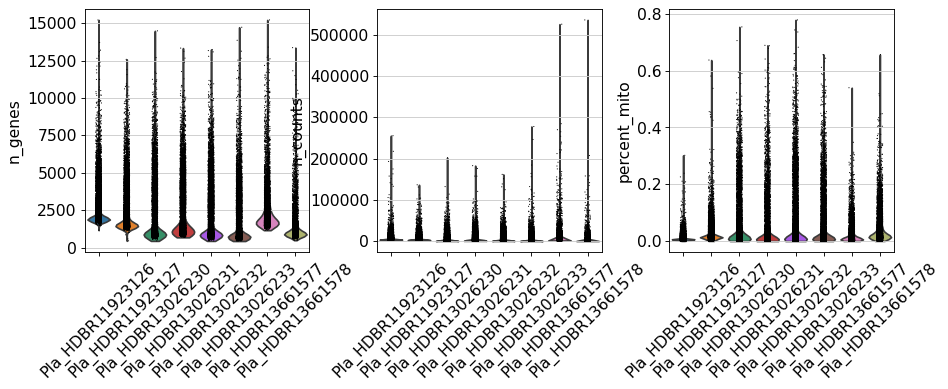

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts','percent_mito'], groupby='sample', rotation=45)

In [16]:
adata.obs['sample'].values.describe()

,counts,freqs
categories,,
Pla_HDBR11923126,22821,0.200443
Pla_HDBR11923127,19016,0.167022
Pla_HDBR13026230,12219,0.107323
Pla_HDBR13026231,10759,0.094499
Pla_HDBR13026232,15881,0.139487
Pla_HDBR13026233,14784,0.129852
Pla_HDBR13661577,8194,0.071970
Pla_HDBR13661578,10179,0.089405


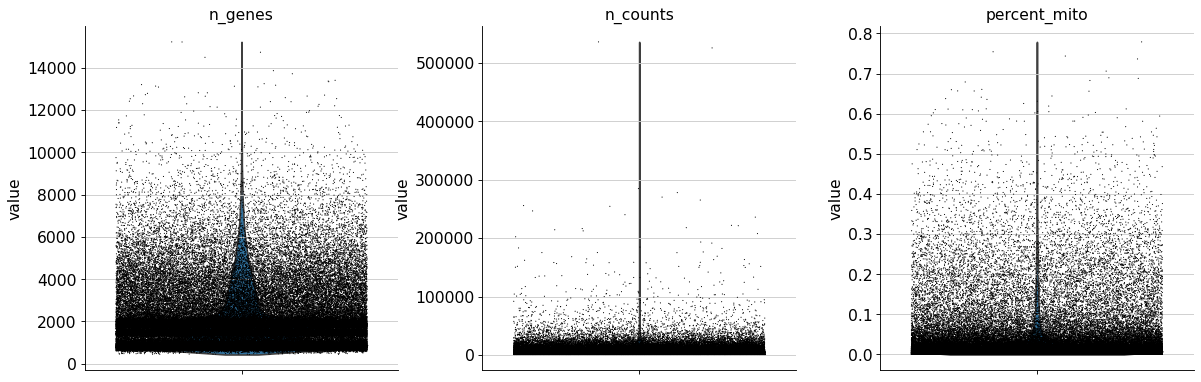

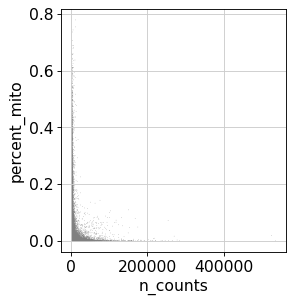

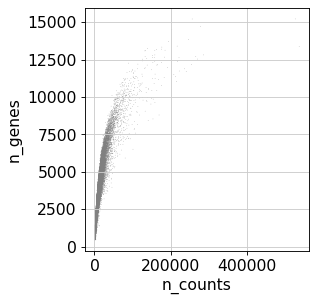

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],jitter=0.4, multi_panel=True, save='Pf.pdf', show=True)
sc.pl.scatter(adata, x='n_counts', y='percent_mito', save='_numiVSmito_Pf.pdf', show=True)
sc.pl.scatter(adata, x='n_counts', y='n_genes', save='_numiVSngenes_Pf.pdf', show=True)

In [18]:
adata.obs['sample_barcode'] = adata.obs_names

# Souporcell
Adding another column with deconvolution from souporcell

In [19]:
list(np.unique(adata.obs['sample']))

['Pla_HDBR11923126',
 'Pla_HDBR11923127',
 'Pla_HDBR13026230',
 'Pla_HDBR13026231',
 'Pla_HDBR13026232',
 'Pla_HDBR13026233',
 'Pla_HDBR13661577',
 'Pla_HDBR13661578']

In [20]:
#Only the multiplexed samples are included here
samples= list(np.unique(adata.obs['sample']))

In [21]:
###reading in souporcell outputs
###

soc_path='/lustre/scratch126/cellgen/team292/er13/PlacInfection_revision/snRNAseq/data_integration/data/Malaria/souporcell_donor/'


# sample to cluster
souporcell_clusters = {}


for sample in samples:
    print('sample', sample)
    path =soc_path+sample+'/clusters.tsv' #path to the souporcell output
    souporcell_clusters[sample] = pd.read_csv(path, sep='\t') #read souporcell output as pandas DF
    #aadind the DF into the dictionary
    souporcell_clusters[sample]['sample_barcode'] = [sample+'_'+j for j in souporcell_clusters[sample]['barcode']]
    souporcell_clusters[sample]['sample_barcode'] = [elem.split('-')[0] for elem in souporcell_clusters[sample]['sample_barcode']]
    souporcell_clusters[sample].set_index('sample_barcode', drop=False, inplace=True)

sample Pla_HDBR11923126
sample Pla_HDBR11923127
sample Pla_HDBR13026230
sample Pla_HDBR13026231
sample Pla_HDBR13026232
sample Pla_HDBR13026233
sample Pla_HDBR13661577
sample Pla_HDBR13661578


In [22]:
#Adding a column into the metada that is actually the cell ID
adata.obs['sample_barcode'] = adata.obs.index

In [23]:
%%time
adata.obs['assignment_SoC'] = adata.obs['sample_barcode'].apply(lambda x: add_souporcell_id(adata,x,samples))

CPU times: user 1min 50s, sys: 0 ns, total: 1min 50s
Wall time: 1min 50s


#### Deconvolution of the donors
This step must be done even if there are not defined donors, in order to annotate the doublets.
The deconvolution of cluster equivalents was done using SoC shared_samples.py script. The loss values for true pairs must be low, in some cases, 1/10th that of invalid pairs.

In [24]:
### Building a dictionary with the identity of the cluster in each one of the samples.
### It has the structure SAMPLE:{Cluster:Donor,Cluster:Donor}




# NOTE: as donors 0 and 1 correspond to Hrv107_Hrv124. For the samples Hrv168_Hrv170, I will use donor 2 and 3. i.e. 0=2, 1=3.
    
    
identity_dict={
    "Pla_HDBR11923126":{'0':'0','1':'1'},
    "Pla_HDBR11923127":{'0':'0','1':'1'},
    
    #these samples have a different set of donors
    #to avoid repetition of clusters between multiplexed samples for these samples 0=2, 1=3
    "Pla_HDBR13026230":{'0':'2','1':'3'}, 
    "Pla_HDBR13026231":{'0':'3','1':'2'},  
    "Pla_HDBR13026232":{'0':'3','1':'2'},#'0':'1'=3 , '1':'0'= 2
    "Pla_HDBR13026233":{'0':'3','1':'2'}, #'0':'1'=3 , '1':'0'= 2
    
    #these samples have a different set of donors
    #to avoid repetition of clusters between multiplexed samples for these samples 0=4, 1=5, 2=6
    "Pla_HDBR13661577":{'0':'4', '1':'5', '2':'6'}, 
    "Pla_HDBR13661578":{'0':'5', '1':'6', '2':'4'},
    #"Pla_HDBR13837194":{'0':'5', '1':'6', '2':'5'},
    #"Pla_HDBR13837195":{'0':'5', '1':'6', '2':'5'}
}

identity_dict

{'Pla_HDBR11923126': {'0': '0', '1': '1'},
 'Pla_HDBR11923127': {'0': '0', '1': '1'},
 'Pla_HDBR13026230': {'0': '2', '1': '3'},
 'Pla_HDBR13026231': {'0': '3', '1': '2'},
 'Pla_HDBR13026232': {'0': '3', '1': '2'},
 'Pla_HDBR13026233': {'0': '3', '1': '2'},
 'Pla_HDBR13661577': {'0': '4', '1': '5', '2': '6'},
 'Pla_HDBR13661578': {'0': '5', '1': '6', '2': '4'}}

In [25]:
%%time
#NOTE: cells that weren't pooled will have None in the donor_deconv column
adata.obs['donor_deconv'] = adata.obs['sample_barcode'].apply(lambda x: decode_donors(adata,x,identity_dict, samples))

CPU times: user 2.36 s, sys: 0 ns, total: 2.36 s
Wall time: 2.36 s


In [26]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,n_genes,sample_barcode,assignment_SoC,donor_deconv
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0,1942,Pla_HDBR11923126_AAACCCAAGACCAACG,1,1
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0,1882,Pla_HDBR11923126_AAACCCAAGAGAGGGC,1,1
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0,1832,Pla_HDBR11923126_AAACCCAAGCGAACTG,1/0,donor_doublets
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0,1777,Pla_HDBR11923126_AAACCCAAGGATTTGA,1,1
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0,1902,Pla_HDBR11923126_AAACCCAAGTACTGTC,1/0,donor_doublets


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'filtered_by_souporcell'),
  Text(1, 0, 'donor_doublets'),
  Text(2, 0, '5'),
  Text(3, 0, '6'),
  Text(4, 0, '4')])

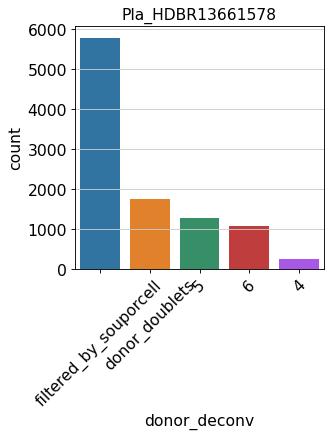

In [27]:
plt.title(sample)
sns.countplot(adata[adata.obs['sample'] == sample].obs['donor_deconv'],
                order=adata[adata.obs['sample'] == sample].obs['donor_deconv'].value_counts().index).set_title(sample)

plt.savefig(fig_path+'countplot_souporcellID_Pf.pdf')
plt.xticks(rotation=45)

In [28]:
adata.obs["donor_deconv"] 

Pla_HDBR11923126_AAACCCAAGACCAACG                         1
Pla_HDBR11923126_AAACCCAAGAGAGGGC                         1
Pla_HDBR11923126_AAACCCAAGCGAACTG            donor_doublets
Pla_HDBR11923126_AAACCCAAGGATTTGA                         1
Pla_HDBR11923126_AAACCCAAGTACTGTC            donor_doublets
                                              ...          
Pla_HDBR13661578_TTTGTTGGTTAAGTCC                         5
Pla_HDBR13661578_TTTGTTGGTTTCTTAC    filtered_by_souporcell
Pla_HDBR13661578_TTTGTTGTCAACTACG            donor_doublets
Pla_HDBR13661578_TTTGTTGTCACTAGCA                         6
Pla_HDBR13661578_TTTGTTGTCCCTCTCC    filtered_by_souporcell
Name: donor_deconv, Length: 113853, dtype: object

#### Applying the donor_assing function to the data. The donor names will be stored in the new column donor_souporcell

In [29]:
adata.obs['donor_souporcell'] = adata.obs['sample_barcode'].apply(lambda x: donor_assing(adata,x))

In [30]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,n_genes,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0,1942,Pla_HDBR11923126_AAACCCAAGACCAACG,1,1,1
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0,1882,Pla_HDBR11923126_AAACCCAAGAGAGGGC,1,1,1
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0,1832,Pla_HDBR11923126_AAACCCAAGCGAACTG,1/0,donor_doublets,donor_doublets
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0,1777,Pla_HDBR11923126_AAACCCAAGGATTTGA,1,1,1
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0,1902,Pla_HDBR11923126_AAACCCAAGTACTGTC,1/0,donor_doublets,donor_doublets
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661578_TTTGTTGGTTAAGTCC,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.008166,21431.0,7,5748,Pla_HDBR13661578_TTTGTTGGTTAAGTCC,0,5,5
Pla_HDBR13661578_TTTGTTGGTTTCTTAC,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.023427,1494.0,7,1076,Pla_HDBR13661578_TTTGTTGGTTTCTTAC,filtered_by_souporcell,filtered_by_souporcell,filtered_by_souporcell
Pla_HDBR13661578_TTTGTTGTCAACTACG,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.017454,974.0,7,750,Pla_HDBR13661578_TTTGTTGTCAACTACG,2/1,donor_doublets,donor_doublets
Pla_HDBR13661578_TTTGTTGTCACTAGCA,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.010384,963.0,7,764,Pla_HDBR13661578_TTTGTTGTCACTAGCA,1,6,6


In [31]:
#Deleting the cells filtered by soc
adata= adata[adata.obs['assignment_SoC'] != 'filtered_by_souporcell']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [32]:
adata.obs.head()

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,n_genes,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0,1942,Pla_HDBR11923126_AAACCCAAGACCAACG,1,1,1
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0,1882,Pla_HDBR11923126_AAACCCAAGAGAGGGC,1,1,1
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0,1832,Pla_HDBR11923126_AAACCCAAGCGAACTG,1/0,donor_doublets,donor_doublets
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0,1777,Pla_HDBR11923126_AAACCCAAGGATTTGA,1,1,1
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0,1902,Pla_HDBR11923126_AAACCCAAGTACTGTC,1/0,donor_doublets,donor_doublets


#### Assigning donor id to cluster
I had deconvoluted and matched the 3 different donors in my data set, however I don't really know what cluster is each one of the donors.

I will assing *Randomly* an ID to each cluster, this won't affect my analysis or results but it's good to keep in mind in case of any specific validation of donors.

0= snDonor_Pf0, 1= snDonor_Pf1, 2= snDonor_Pf2, 3= snDonor_Pf3

In [33]:
set(list(adata.obs.donor_souporcell))

{'0', '1', '2', '3', '4', '5', '6', 'donor_doublets'}

In [34]:
#Function that changes the cluster names as indicated
adata.obs['donor_id'] = (adata.obs["donor_souporcell"].map(lambda x: 
                            {"0": "snDonor_Pf0", "1": "snDonor_Pf1", "2": "snDonor_Pf2", "3": "snDonor_Pf3",
                             "4": "snDonor_Pf4", "5": "snDonor_Pf5", "6": "snDonor_Pf6", "donor_doublets":"donor_doublets" }
                            .get(x, x)).astype("category"))

Trying to set attribute `.obs` of view, copying.


In [35]:
set(list(adata.obs.donor_id))

{'donor_doublets',
 'snDonor_Pf0',
 'snDonor_Pf1',
 'snDonor_Pf2',
 'snDonor_Pf3',
 'snDonor_Pf4',
 'snDonor_Pf5',
 'snDonor_Pf6'}

In [36]:
print('Total number of cells: {:d}'.format(adata.n_obs))

Total number of cells: 105409


In [37]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,n_genes,sample_barcode,assignment_SoC,donor_deconv,donor_souporcell,donor_id
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0,1942,Pla_HDBR11923126_AAACCCAAGACCAACG,1,1,1,snDonor_Pf1
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0,1882,Pla_HDBR11923126_AAACCCAAGAGAGGGC,1,1,1,snDonor_Pf1
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0,1832,Pla_HDBR11923126_AAACCCAAGCGAACTG,1/0,donor_doublets,donor_doublets,donor_doublets
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0,1777,Pla_HDBR11923126_AAACCCAAGGATTTGA,1,1,1,snDonor_Pf1
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0,1902,Pla_HDBR11923126_AAACCCAAGTACTGTC,1/0,donor_doublets,donor_doublets,donor_doublets
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661578_TTTGTTGGTATATGGA,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.018505,1405.0,7,1117,Pla_HDBR13661578_TTTGTTGGTATATGGA,1,6,6,snDonor_Pf6
Pla_HDBR13661578_TTTGTTGGTGACTAAA,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.082421,2924.0,7,1703,Pla_HDBR13661578_TTTGTTGGTGACTAAA,0,5,5,snDonor_Pf5
Pla_HDBR13661578_TTTGTTGGTTAAGTCC,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.008166,21431.0,7,5748,Pla_HDBR13661578_TTTGTTGGTTAAGTCC,0,5,5,snDonor_Pf5
Pla_HDBR13661578_TTTGTTGTCAACTACG,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.017454,974.0,7,750,Pla_HDBR13661578_TTTGTTGTCAACTACG,2/1,donor_doublets,donor_doublets,donor_doublets


In [38]:
adata.obs['donor_id'].value_counts()

donor_doublets    49747
snDonor_Pf1       15309
snDonor_Pf2       14425
snDonor_Pf3       12636
snDonor_Pf0        6112
snDonor_Pf6        5132
snDonor_Pf5        1709
snDonor_Pf4         339
Name: donor_id, dtype: int64

In [39]:
adata.obs['sample'].value_counts()

Pla_HDBR11923126    22821
Pla_HDBR11923127    19016
Pla_HDBR13026232    15881
Pla_HDBR13026233    14784
Pla_HDBR13026230    12219
Pla_HDBR13026231    10759
Pla_HDBR13661577     5536
Pla_HDBR13661578     4393
Name: sample, dtype: int64

In [39]:
#deleting donor column to avoid confusion
#adata.obs= adata.obs.drop(columns='donor')

## Load scrublet

In [48]:
scorenames = ['scrublet_score','scrublet_cluster_score','zscore','bh_pval','bonf_pval']

scrdf = []
for sample in meta.index:
    scrdf.append(pd.read_csv(data_dir+'scrublet-scores/'+sample+'.csv', header=0, index_col=0))
    
scrdf = pd.concat(scrdf)
scrdf.index = [i.replace('-1', '') for i in scrdf.index]
for score in scorenames:
    adata.obs[score] = scrdf[score]
adata.obs['is_doublet'] = adata.obs['bonf_pval'] < 0.01

In [49]:
print('Total number of doublets: {:d}'.format(len(adata.obs.loc[adata.obs['is_doublet'] == True])))

Total number of doublets: 490


In [50]:
#concatenating columns and creating new one
adata.obs["infection_stage"] = adata.obs["infection"].astype('string') +'_'+ adata.obs["hpi"].astype('string')
adata.obs["infection_stage"] = adata.obs["infection_stage"].astype("category")

In [51]:
set(adata.obs["infection_stage"])

{'Pf_24h', 'Pf_48h', 'UI_24h', 'UI_48h'}

In [52]:
# adding the raw counts
adata.layers['raw_counts']=adata.X.copy()

In [53]:
adata

AnnData object with n_obs × n_vars = 105409 × 42294
    obs: 'sample', 'stage', 'donor', 'hpi', 'infection', 'percent_mito', 'n_counts', 'batch', 'n_genes', 'sample_barcode', 'assignment_SoC', 'donor_deconv', 'donor_souporcell', 'donor_id', 'scrublet_score', 'scrublet_cluster_score', 'zscore', 'bh_pval', 'bonf_pval', 'is_doublet', 'infection_stage'
    var: 'gene_ids', 'feature_types'
    uns: 'sample_colors'
    layers: 'raw_counts'

## Calculate cell-cycle scores AND (optional)regress out cell cycle genes

We here perform cell cycle scoring. To score a gene list, the algorithm calculates the difference of mean expression of the given list and the mean expression of reference genes. To build the reference, the function randomly chooses a bunch of genes matching the distribution of the expression of the given list. Cell cycle scoring adds three slots in data, a score for S phase, a score for G2M phase and the predicted cell cycle phase.

First read the file with cell cycle genes, from Regev lab and split into S and G2M phase genes. Cell cycle genes were retrieved from the scanpy_usage github site via web browser at RegevLab Github repo.

In [54]:
#Normalizing the data and scaling for the cell-cycle scoring
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)


# Scale
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [56]:
# Regress out cell cycle genes
cell_cycle_genes = [x.strip() for x in open('../../data_integration/data/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
# sc.pp.regress_out(adata, ['S_score', 'G2M_score']

/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [57]:
adata.obs

,sample,stage,donor,hpi,infection,percent_mito,n_counts,batch,n_genes,sample_barcode,...,scrublet_score,scrublet_cluster_score,zscore,bh_pval,bonf_pval,is_doublet,infection_stage,S_score,G2M_score,phase
Pla_HDBR11923126_AAACCCAAGACCAACG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.017820,4770.0,0,1942,Pla_HDBR11923126_AAACCCAAGACCAACG,...,0.294630,0.333333,2.398675,0.122763,1.0,False,UI_24h,0.233446,-0.008155,S
Pla_HDBR11923126_AAACCCAAGAGAGGGC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.007278,4397.0,0,1882,Pla_HDBR11923126_AAACCCAAGAGAGGGC,...,0.159785,0.255814,0.592159,0.967851,1.0,False,UI_24h,0.268706,-0.132457,S
Pla_HDBR11923126_AAACCCAAGCGAACTG,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.003882,4379.0,0,1832,Pla_HDBR11923126_AAACCCAAGCGAACTG,...,0.177843,0.236364,0.138888,0.967851,1.0,False,UI_24h,0.130806,0.201731,G2M
Pla_HDBR11923126_AAACCCAAGGATTTGA,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.005391,4266.0,0,1777,Pla_HDBR11923126_AAACCCAAGGATTTGA,...,0.147208,0.224680,-0.133391,0.967851,1.0,False,UI_24h,-0.036160,-0.031802,G1
Pla_HDBR11923126_AAACCCAAGTACTGTC,Pla_HDBR11923126,UI_24h,Hrv107_Hrv124,24h,UI,0.034125,4718.0,0,1902,Pla_HDBR11923126_AAACCCAAGTACTGTC,...,0.095995,0.075649,-3.606418,0.999988,1.0,False,UI_24h,0.065222,0.121824,G2M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Pla_HDBR13661578_TTTGTTGGTATATGGA,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.018505,1405.0,7,1117,Pla_HDBR13661578_TTTGTTGGTATATGGA,...,0.120000,0.142857,-0.559540,0.886275,1.0,False,Pf_24h,-0.221132,0.058688,G2M
Pla_HDBR13661578_TTTGTTGGTGACTAAA,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.082421,2924.0,7,1703,Pla_HDBR13661578_TTTGTTGGTGACTAAA,...,0.110410,0.149540,-0.360505,0.884026,1.0,False,Pf_24h,-0.141117,-0.325577,G1
Pla_HDBR13661578_TTTGTTGGTTAAGTCC,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.008166,21431.0,7,5748,Pla_HDBR13661578_TTTGTTGGTTAAGTCC,...,0.076535,0.134615,-0.805011,0.890913,1.0,False,Pf_24h,0.264426,-0.106102,S
Pla_HDBR13661578_TTTGTTGTCAACTACG,Pla_HDBR13661578,Pf_24h,Hrv225_Hrv232_Hrv236,24h,Pf,0.017454,974.0,7,750,Pla_HDBR13661578_TTTGTTGTCAACTACG,...,0.113490,0.138650,-0.684836,0.886275,1.0,False,Pf_24h,-0.063769,-0.057326,G1


### Save raw counts

In [58]:
# adding the raw counts
adata.X= adata.layers['raw_counts'].copy()

#adata.raw = adata.copy
adata.write('../data/snRNA1_counts_Pf_adata.h5ad')

... storing 'assignment_SoC' as categorical
... storing 'donor_deconv' as categorical
... storing 'donor_souporcell' as categorical
... storing 'phase' as categorical


In [51]:
adata=sc.read('../data/snRNA1_counts_Pf_adata.h5ad')


## Plasmodium counts preview

## Preview of Plasmodium gondii UMIs

Looking at the human and Pf genes.

All the Tg genes have the preffix "PF3D7" 

In [52]:
adata.var.tail()

,gene_ids,feature_types,mean,std
RIF-180,PF3D7_0115300,Gene Expression,0.000000,1.000000
PF3D7_0115400,PF3D7_0115400,Gene Expression,0.000000,1.000000
PF3D7_0115500,PF3D7_0115500,Gene Expression,0.000000,1.000000
RIF-181,PF3D7_0115600,Gene Expression,0.000227,0.022526
VAR-79,PF3D7_0115700,Gene Expression,0.001934,0.053142


In [53]:
## Selecting the names of the Pf genes only
pf= adata.var.index.str.contains('PF3D7')
print(sum(pf))

3631


<ipython-input-2-b5d44fa15e4e>:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+ suffix+'.pdf', bbox_inches='tight',


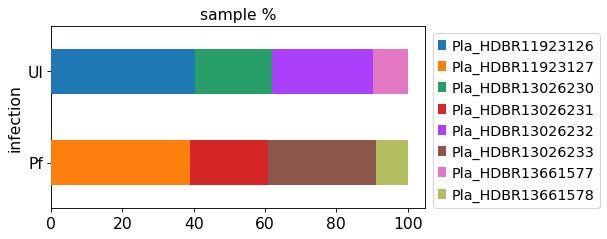

In [54]:
## --- To be run once the deconvolution is completed

Barplot('sample', adata, var= 'infection')

#### Giving a flag to differentiate human and Tg genes in my data set. Preview of counts

In [55]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata.var['hs'] = adata.var.gene_ids.str.startswith('ENSG') ## all human genes
adata.var['pf'] = adata.var.gene_ids.str.startswith('PF3D7') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

In [56]:
## Look at the hs and tg columns
adata.var

,gene_ids,feature_types,mean,std,hs,pf,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
MIR1302-2HG,ENSG00000243485,Gene Expression,0.000023,0.003774,True,False,5,0.000047,99.995257,5.0
FAM138A,ENSG00000237613,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0
OR4F5,ENSG00000186092,Gene Expression,0.000012,0.002740,True,False,2,0.000019,99.998103,2.0
AL627309.1,ENSG00000238009,Gene Expression,0.007815,0.088148,True,False,1268,0.013054,98.797067,1376.0
AL627309.3,ENSG00000239945,Gene Expression,0.000000,1.000000,True,False,0,0.000000,100.000000,0.0
...,...,...,...,...,...,...,...,...,...,...
RIF-180,PF3D7_0115300,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
PF3D7_0115400,PF3D7_0115400,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
PF3D7_0115500,PF3D7_0115500,Gene Expression,0.000000,1.000000,False,True,0,0.000000,100.000000,0.0
RIF-181,PF3D7_0115600,Gene Expression,0.000227,0.022526,False,True,11,0.000171,99.989564,18.0


## Checking plasmodium UMIs

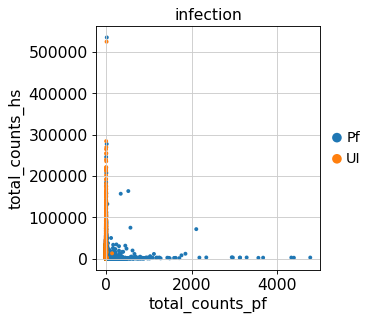

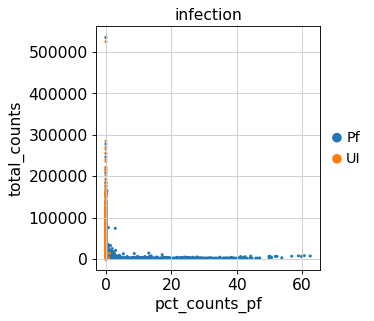

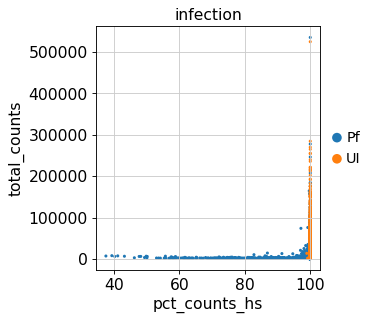

In [57]:
sc.pl.scatter(adata, x='total_counts_pf', y='total_counts_hs',  color="infection",size=50, save='_HsPfCounts.pdf')
sc.pl.scatter(adata, x='pct_counts_pf', y='total_counts', color="infection", size=30, save='_TotalvsPf.pdf')
sc.pl.scatter(adata, x='pct_counts_hs', y='total_counts', color="infection", size=30, save='_TotalvsHs-Pf.pdf')

In [64]:
adata1 = adata[adata.obs['sample'].isin(['Pla_HDBR11923126'])]
adata2 = adata[adata.obs['sample'].isin(['Pla_HDBR11923127'])]
adata3 = adata[adata.obs['sample'].isin(['Pla_HDBR13026230'])]
adata4 = adata[adata.obs['sample'].isin(['Pla_HDBR13026231'])]

adata5 = adata[adata.obs['sample'].isin(['Pla_HDBR13026232'])]
adata6 = adata[adata.obs['sample'].isin(['Pla_HDBR13026233'])]


adata7 = adata[adata.obs['sample'].isin(['Pla_HDBR13661577'])]
adata8 = adata[adata.obs['sample'].isin(['Pla_HDBR13661578'])]
adata9 = adata[adata.obs['sample'].isin(['Pla_HDBR13837194'])]
adata10 = adata[adata.obs['sample'].isin(['Pla_HDBR13837195'])]


/opt/conda/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


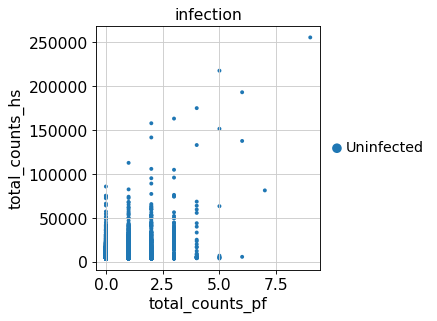

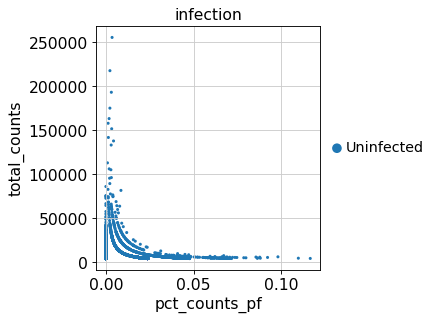

In [10]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata1.var['hs'] = adata1.var.gene_ids.str.startswith('ENSG') ## all human genes
adata1.var['pf'] = adata1.var.gene_ids.str.startswith('PF3D7') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata1, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata1, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata1, x='total_counts_pf', y='total_counts_hs',  color="infection",size=50)
sc.pl.scatter(adata1, x='pct_counts_pf', y='total_counts', color="infection", size=30)

Trying to set attribute `.var` of view, copying.


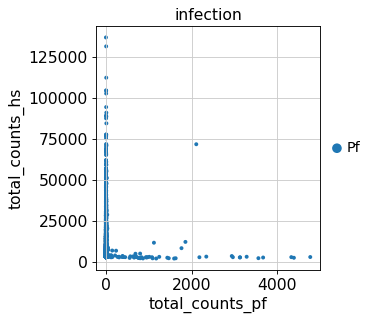

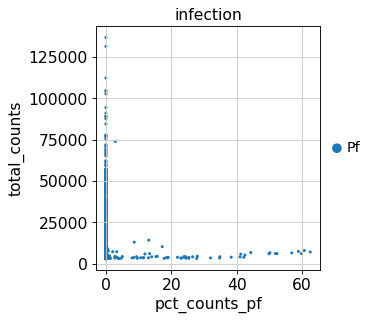

In [11]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata2.var['hs'] = adata2.var.gene_ids.str.startswith('ENSG') ## all human genes
adata2.var['pf'] = adata2.var.gene_ids.str.startswith('PF3D7') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata2, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata2, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata2, x='total_counts_pf', y='total_counts_hs',  color="infection",size=50)
sc.pl.scatter(adata2, x='pct_counts_pf', y='total_counts', color="infection", size=30)

Trying to set attribute `.var` of view, copying.


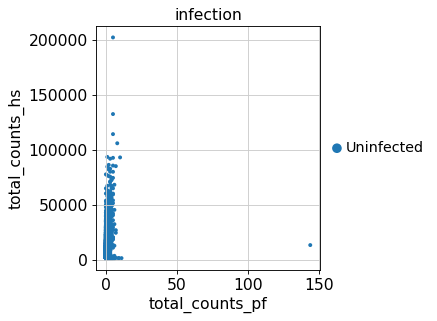

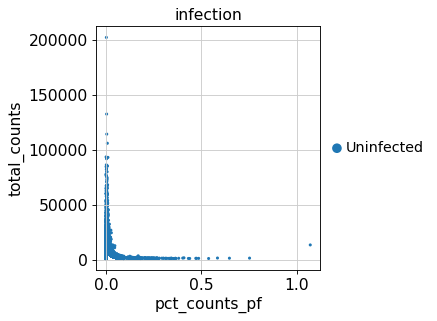

In [12]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata3.var['hs'] = adata3.var.gene_ids.str.startswith('ENSG') ## all human genes
adata3.var['pf'] = adata3.var.gene_ids.str.startswith('PF3D7') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata3, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata3, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata3, x='total_counts_pf', y='total_counts_hs',  color="infection",size=50)
sc.pl.scatter(adata3, x='pct_counts_pf', y='total_counts', color="infection", size=30)

Trying to set attribute `.obs` of view, copying.


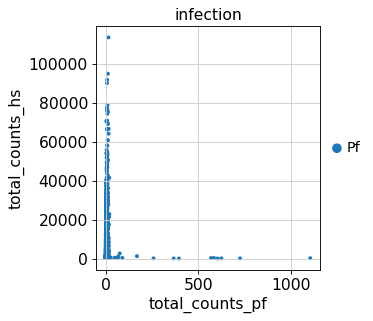

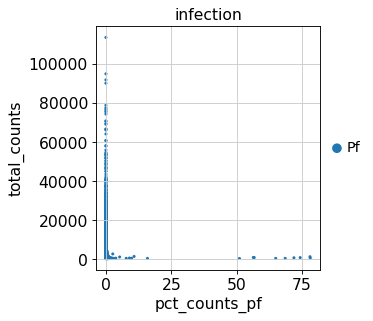

In [71]:
## Giving a flag to differentiate human and Tg genes in my data set
##
adata3.var['hs'] = adata10.var.gene_ids.str.startswith('ENSG') ## all human genes
adata3.var['pf'] = adata10.var.gene_ids.str.startswith('PF3D7') ## all toxoplasma genes


## Calculating the metrics per cell in my data.
sc.pp.calculate_qc_metrics(adata10, qc_vars=['hs'], percent_top=None, log1p=False, inplace=True)
sc.pp.calculate_qc_metrics(adata10, qc_vars=['pf'], percent_top=None, log1p=False, inplace=True)

sc.pl.scatter(adata10, x='total_counts_pf', y='total_counts_hs',  color="infection",size=50)
sc.pl.scatter(adata10, x='pct_counts_pf', y='total_counts', color="infection", size=30)

## Save raw counts

In [58]:
# adding the raw counts
adata.X=adata.layers['raw_counts'].copy()
#adata.raw = adata.copy
adata.write('../data/snRNA1_counts_Pf_adata.h5ad')